<a href="https://colab.research.google.com/github/Adrok24/Proyecto-Integrador/blob/main/T-VAE-Attemp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install tensorflow-datasets==1.2.0

     |████████████████████████████████| 2.3MB 9.8MB/s 
  Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds

import os
import re
import numpy as np

import matplotlib.pyplot as plt

tf.random.set_seed(1234)


In [37]:
from tensorflow.keras.layers import Layer, Dense
import tensorflow.keras.backend as K

In [5]:
## Vamos a bajarnos el dataset de dialogos de peliculas de Cornell University
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin=
    'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,
                                           'movie_conversations.txt')

9920512/9916637 [==============================] - 1s 0us/step


### Preprocesamiento

In [6]:
# Numero máximo de samples a preprocesar
MAX_SAMPLES = 50000

def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()
  # vamos a crear espacios entre las frases y los puntos:
  # ej: "he is a boy." => "he is a boy ."
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  # reemplazamos por espacios todo lo que no sea (a-z, A-Z, ".", "?", "!", ",")
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence


def load_conversations():
  id2line = {}
  ## levanto las frases
  with open(path_to_movie_lines, errors='ignore') as file:
    lines = file.readlines()

  ## y me quedo solo con id de frase y texto
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]

  inputs, outputs = [], []
  with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    ## me quedo con las conversaciones
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]

    ## nos quedamos con las frases consecutivas: una va a ser usada 
    ## como "pregunta" y la otra como "respuesta"
    for i in range(len(conversation) - 1):
      inputs.append(preprocess_sentence(id2line[conversation[i]]))
      outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))
      if len(inputs) >= MAX_SAMPLES:
        return inputs, outputs
  return inputs, outputs


questions, answers = load_conversations()

In [7]:
## ejemplo:
print("Linea 1")
print(questions[0])
print(answers[0])
print()
print("Linea 2")
print(questions[1])
print(answers[1])
print()
print("Linea 3")
print(questions[2])
print(answers[2])

Linea 1
can we make this quick ? roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad . again .
well , i thought we d start with pronunciation , if that s okay with you .

Linea 2
well , i thought we d start with pronunciation , if that s okay with you .
not the hacking and gagging and spitting part . please .

Linea 3
not the hacking and gagging and spitting part . please .
okay . . . then how bout we try out some french cuisine . saturday ? night ?


In [8]:
## tokenizador de subwords
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

## Recien ahora ponemos los tokens de inicio y fin (sino el tokenizador me los rompe)
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Le agrego al tamaño del vocab los dos tokens especiales
VOCAB_SIZE = tokenizer.vocab_size + 2

In [9]:
## el tokenizador tiene dos metodos: encode y decode:
print(tokenizer.encode("hello"))
print(tokenizer.decode(tokenizer.encode("hello")))

[409]
hello


In [10]:
# Vamos a definir un largo maximo de frase
MAX_LENGTH = 50

# Tokenizamos, filtramos las secuencias menores al largo maximo
# y las paddeamos 
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # tokenizamos + tokens especiales
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
    # filtramos
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # paddeamos
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs


questions, answers = tokenize_and_filter(questions, answers)

In [11]:
print('Tamaño vocabulario: {}'.format(VOCAB_SIZE))
print('Pares de frases: {}'.format(len(questions)))

Tamaño vocabulario: 8333
Pares de frases: 46576


In [12]:
### ver de modificar ESTO

BATCH_SIZE = 64
BUFFER_SIZE = 20000

# saco el token de start de los outputs
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))


dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

### Elementos básicos

In [13]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculamos attention weights """

  ## hacemos el producto de query por la transpuesta de key
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  ## escalamos por la raiz cuadrado del # dims
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  ## agregamos la mascara
  if mask is not None:
    logits += (mask * -1e9)

  ## aplicamos la softmax
  attention_weights = tf.nn.softmax(logits, axis=-1)

  ## y multiplicamos por value 
  output = tf.matmul(attention_weights, value)

  return output

In [113]:
class MultiHeadAttention(tf.keras.layers.Layer):

  ''' Vamos a armar la capa para multihead attention '''

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)

    ## que es este super?
    ## super() te permite acceeder a los metodos de la super clase de la cual
    ## la subclase está heredando. En este caso, estas herendando de Layers.
        
    ## definimos algunos parametros: cuantas cabezas va a tener self attention 
    ## y la dimensionalidad del embedding
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    ## cuantas dimensiones va a tener cada cabeza:
    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    ## vamos a armar la division en cabezas. 
    ## se va a entender mejor en el siguiente bloque de codigo
    ## por ahora es solamente la forma en la que 
    ## reacomodamos los datos para armar las cabezas
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    ''' Este call es el metodo que  va a llamar keras para usar la capa'''

    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    print(self.name, mask)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    # acomodamos las dimensiones
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenamos las cabezas
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

In [138]:
## creamos una mascara para el padding (asi nos nos molesta)
## con esto lo que hacemos es despues pasarselo a la capa 
## anterior y eliminamos los paddings

def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  print("create_padding:", mask[:, tf.newaxis, tf.newaxis, :], "X:", x)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [115]:
## vamos a mostrar como funciona:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [144]:
## vamos a crear la otra mascara:
## ahora queremos la mascara para no ver el futuro
## vamos a incorporarle tambien la mascara para el padding

def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)

  ## aca la mascara para el padding
  padding_mask = create_padding_mask(x)
  print("LH:", look_ahead_mask.shape, "PM:", padding_mask.shape, "X:", x)
  print(tf.maximum(look_ahead_mask, padding_mask))
  return look_ahead_mask

In [130]:
print(create_look_ahead_mask(tf.constant([[0,1, 2,3,4, 5,6,7]])))

LH: (8, 8) PM: (1, 1, 1, 8) X: tf.Tensor([[0 1 2 3 4 5 6 7]], shape=(1, 8), dtype=int32)
tf.Tensor(
[[[[1. 1. 1. 1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1. 1. 1. 1.]
   [1. 0. 0. 1. 1. 1. 1. 1.]
   [1. 0. 0. 0. 1. 1. 1. 1.]
   [1. 0. 0. 0. 0. 1. 1. 1.]
   [1. 0. 0. 0. 0. 0. 1. 1.]
   [1. 0. 0. 0. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(1, 1, 8, 8), dtype=float32)


In [118]:
a = tf.constant([2,4,6])
b = tf.constant([1,3,5])

In [119]:
c= tf.concat([b,a],axis=-1)

In [120]:
class PositionalEncoding(tf.keras.layers.Layer):
  ''' Armamos los encodings de posición '''

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  ## comparar con formula de la teorica
  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

   
  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # seno a los indices pares
    sines = tf.math.sin(angle_rads[:, 0::2])
    # coseno a los impares
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, :]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### Encoder

In [121]:
class Sampling(Layer):
    def call(self, inputs):
        mu, log_var = inputs
        epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
        return mu + K.exp(log_var / 2) * epsilon

In [122]:
## ya tenemos todos los ingredientes para armar una capa de encoder
## todavía no es el encoder entero!

def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [123]:
## ahora si: el encoder
## vamos a definir una funcion que nos devuelva un modelo que tenga
## num_layers bloques de encoder:

def encoder(vocab_size, num_layers, units, d_model, num_heads,
            dropout, name="encoder"):
  
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  ## partimos de los embeddings
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  ## y les sumamos el positional encoding
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  ## y usamos tantos bloques como querramos
  for i in range(num_layers):
    outputs = encoder_layer(
                            units=units,
                            d_model=d_model,
                            num_heads=num_heads,
                            dropout=dropout,
                            name="encoder_layer_{}".format(i),
                        )([outputs, padding_mask])


  # Generamos la media
  mu = Dense(d_model, name='mu')(outputs) #TODO: revisar la dimensionalidad del espacio latente
  # Generamos el logaritmo de la varianza
  logvar = Dense(d_model, name='logvar')(outputs)
  # Usamos esos parámetros para samplear el espacio latente
  z = Sampling(name='encoder_output')([mu, logvar])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=z, name=name)

### Decoder

In [124]:
## vamos a usar las mismas partes que ya tenemos para armar el decoder
## primero la decoder layer

def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  

  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  #padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': enc_outputs,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': look_ahead_mask
      })

  #Normalization2
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + enc_outputs)

  #FeedFoward
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention1)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)

  #Normalization2
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention1)

  return tf.keras.Model(
      inputs=[enc_outputs, look_ahead_mask],
      outputs=outputs,
      name=name)

In [125]:
## y ahora usamos la decoder layer para el decoder

def decoder(vocab_size, num_layers, units, d_model, num_heads,
            dropout, name='decoder'):
    
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  
  ## la mascara para no ver el futuro y para el padding
  ## ojo que la toma de afuera (es un input, no la creamos aca)

  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  outputs = tf.keras.layers.Dropout(rate=dropout)(enc_outputs)

  ## vamos a tener num_layers bloques de decoders
  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, look_ahead_mask])

  return tf.keras.Model(
      inputs=[enc_outputs, look_ahead_mask],
      outputs=outputs,
      name=name)

### Transformer

In [145]:
def transformer(vocab_size, num_layers, units, d_model, num_heads,
                dropout, name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # instanciamos el encoder y le pasamos el input y la mask
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # vamos a pasar las funciones que arman las mascaras en forma de capas
  # la lookahead
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(enc_outputs)

  # lo que sale del encoder lo pasamos al decoder
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[enc_outputs, look_ahead_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs], outputs=outputs, name=name)

In [146]:
# Hyper-parameters
NUM_LAYERS = 1
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

create_padding: Tensor("enc_padding_mask/strided_slice:0", shape=(None, 1, 1, None), dtype=float32) X: Tensor("Placeholder:0", shape=(None, None), dtype=float32)
attention Tensor("Placeholder_1:0", shape=(None, 1, 1, None), dtype=float32)
attention Tensor("Placeholder_1:0", shape=(None, 1, 1, None), dtype=float32)
attention Tensor("Placeholder_1:0", shape=(None, 1, 1, None), dtype=float32)
create_padding: Tensor("look_ahead_mask/strided_slice_1:0", shape=(None, 1, 1, None, 256), dtype=float32) X: Tensor("Placeholder:0", shape=(None, None, 256), dtype=float32)
LH: (None, None) PM: (None, 1, 1, None, 256) X: Tensor("Placeholder:0", shape=(None, None, 256), dtype=float32)
Tensor("look_ahead_mask/Maximum:0", shape=(None, 1, 1, None, 256), dtype=float32)
attention_1 Tensor("Placeholder_1:0", shape=(None, 1, None, None), dtype=float32)
attention_1 Tensor("Placeholder_1:0", shape=(None, 1, None, None), dtype=float32)


attention_1 Tensor("Placeholder_1:0", shape=(None, None), dtype=float32)


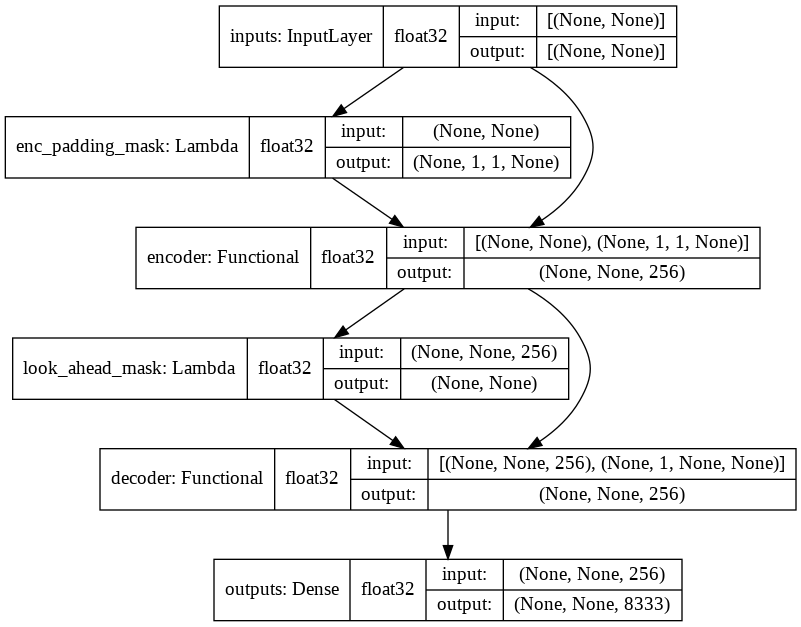

In [147]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [ ]:
## en los ejemplos anteriores maskeamos los 0 desde el embedding
## acá no tenemos eso, así que tenemos que tocar la función de perdida

def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  ## calculamos la loss sin reducir
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  ## aplicamos una mascara
  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  ## y reducimos la loss
  return tf.reduce_mean(loss)

In [ ]:
## nos queda armar el lr que va cambiando con el tiempo
## hay que hacer un schedule de lr:

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):

    '''  Comparar con la formula de la teorica '''
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

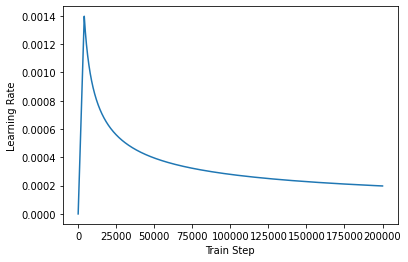

In [ ]:
## veamos que pinta tiene
sample_learning_rate = CustomSchedule(d_model=128)
plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Entrenamiento

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # me aseguro que la forma esté bien
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 20

model.fit(dataset, epochs=EPOCHS)

Epoch 1/20
728/728 [==============================] - 70s 96ms/step - loss: 1.7854 - accuracy: 0.0362
Epoch 2/20
728/728 [==============================] - 69s 95ms/step - loss: 1.2803 - accuracy: 0.0653
Epoch 3/20
728/728 [==============================] - 69s 94ms/step - loss: 1.1951 - accuracy: 0.0713
Epoch 4/20
728/728 [==============================] - 68s 93ms/step - loss: 1.1448 - accuracy: 0.0752
Epoch 5/20
728/728 [==============================] - 68s 93ms/step - loss: 1.1008 - accuracy: 0.0786
Epoch 6/20
728/728 [==============================] - 67s 93ms/step - loss: 1.0602 - accuracy: 0.0814
Epoch 7/20
728/728 [==============================] - 67s 93ms/step - loss: 1.0112 - accuracy: 0.0852
Epoch 8/20
728/728 [==============================] - 68s 93ms/step - loss: 0.9617 - accuracy: 0.0895
Epoch 9/20
728/728 [==============================] - 67s 92ms/step - loss: 0.9159 - accuracy: 0.0940
Epoch 10/20
728/728 [==============================] - 68s 93ms/step - loss: 0.874

## Testeamos

In [ ]:
## definimos dos funciones. Una para ir sacando las predicciones
## la segunda para traducir de vuelta de numero a ingles

def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output])

    # tomamos la ultima palabra
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # y si llegamos al token de finalizacion, paramos
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # concatenamos
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence



In [ ]:
predict("Hello.") 

Input: Hello.
Output: i m sorry . i m sorry . i m sorry . you ve been acting strangely , and i have to see you .


'i m sorry . i m sorry . i m sorry . you ve been acting strangely , and i have to see you .'

In [ ]:
## Conozco gente así.
## Podríamos entrenar con mas texto o por mas tiempo y ver resultados distintos